In [1]:
import sys
sys.path.append('../')

import numpy as np
import legume

%load_ext autoreload
%autoreload 2

In [5]:
# Grating arguments
ymax = 0.1 # supercell length in y-direction, should be smaller than 1/gmax below
W = 0.40 # width of dielectric rods
H = 0.33 # thickness of substate region
D = 0.20 # thickness of grating region
epsrb = 12 # permittivity of substrate
epsrt = 12 # permittivity of grating

# GME arguments
gmax = 5 # plane wave truncation
neig = 10 # number of eigenvalues to be stored

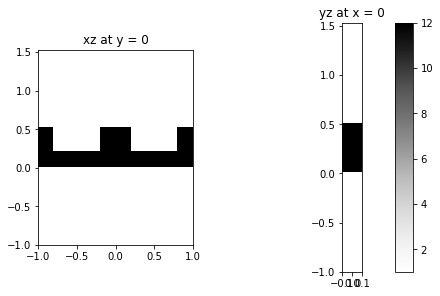

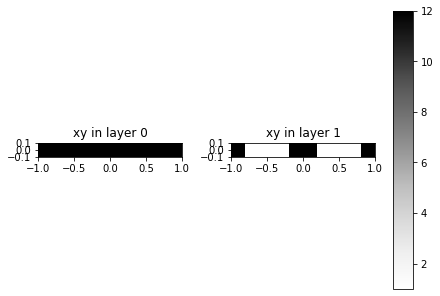

In [11]:
# Build the grating
lattice = legume.Lattice([1, 0], [0, ymax])
phc = legume.PhotCryst(lattice)

# Substrate
phc.add_layer(d=D, eps_b=epsrb)

# Grating
phc.add_layer(d=H, eps_b=1) # Background eps is set to one, we add the rods below
grating = legume.Poly(eps=epsrt, x_edges=np.array([-W / 2, -W / 2, +W / 2, +W / 2]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
phc.layers[-1].add_shape(grating)
phc.plot_overview()

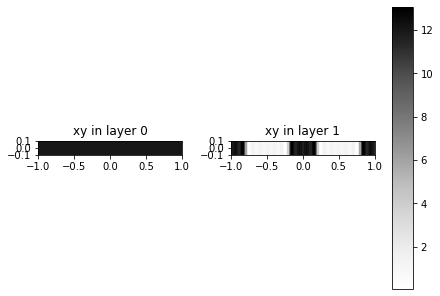

In [12]:
# Initialize GME and plot what we're simulating
gme = legume.GuidedModeExp(phc, gmax=gmax)
gme.plot_overview_ft()

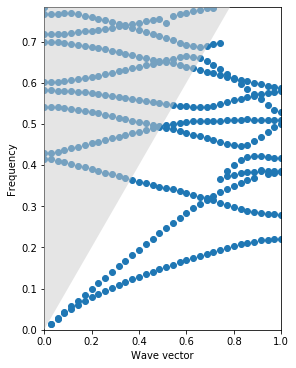

In [9]:
path = phc.lattice.bz_path(['G', np.array([np.pi, 0])], [35])

# See the legume README to understand the options below
options = {'gmode_inds': np.arange(0, 6), 'gmode_npts': 2000, 'numeig': neig, 'verbose': False}

gme.run(kpoints=path.kpoints, **options)

ax = legume.viz.bands(gme)

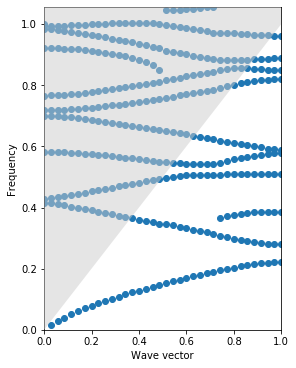

In [14]:
# This is how you can restrict to TE-modes only (take only even gmode_inds)
options = {'gmode_inds': np.arange(0, 6, 2), 'gmode_npts': 2000, 'numeig': neig, 'verbose': False}

gme.run(kpoints=path.kpoints, **options)

ax = legume.viz.bands(gme)

## Loss rates (preliminary!)
The radiative loss rate computation is only impelemnted for TE-slab modes, i.e. even `gmode_idns`. Even then there might be bugs. But here's how you can use that.

In [34]:
kind = 0 # index of the k-point at which you want to get the loss rate
minds = np.arange(0, 4) # mode indexes whose loss rates will be computed

(freqs_im, coup_l, coup_u) = gme.compute_rad(kind=kind, minds=minds)
# Output:
# - freqs_im : imaginary part of the frequencies, such that Q = freqs/2/freqs_im

# These are somewhat preliminary right now so take with a grain of salt:
# - coup_l   : a dictionary containing the coupling constants to TE and TM modes in the lower cladding
# - coup_u   : same for the upper cladding

# Note: all the states at kx = 0 that we just computed are BIC's 
print("Loss rates of first 4 modes at kx = %f are: " % gme.kpoints[0, kind], freqs_im)

Loss rates of first 4 modes at kx = 0.000000 are:  [0. 0. 0. 0.]


In [36]:
kind = 15 # let's try a finite k
(freqs_im, coup_l, coup_u) = gme.compute_rad(kind=kind, minds=minds)
# Note that states below light line still have zero losses
print("Frequencies of first 4 modes at kx = %f are: " % gme.kpoints[0, kind], gme.freqs[kind, minds])
print("Loss rates of first 4 modes at kx = %f are : " % gme.kpoints[0, kind], freqs_im)

Frequencies of first 4 modes at kx = 1.346397 are:  [0.13470025 0.35536651 0.48517028 0.55528922]
Loss rates of first 4 modes at kx = 1.346397 are :  [0.         0.0122729  0.00424748 0.01446444]
